<a href="https://colab.research.google.com/github/monicamuyama/sortify/blob/main/sortify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')


# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize values
])

# Load datasets
data_dir = "/content/drive/MyDrive/sortify/Garbage classification"
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Mounted at /content/drive


In [5]:
import torch.nn as nn

from torchvision import models

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final layer to match your dataset
num_classes = len(train_dataset.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [6]:
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True


In [7]:
import torch.optim as optim

# Define optimizer for the unfrozen parameters only
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [8]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:
def train_model_transfer(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)

            # Adjust learning rate for the next epoch
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model


In [10]:
# Combine dataloaders
dataloaders = {'train': train_loader, 'val': val_loader}

# Train the model
model = train_model_transfer(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
------------------------------
train Loss: 1.3237 Acc: 0.4918
val Loss: 0.9401 Acc: 0.6798
Epoch 2/10
------------------------------
train Loss: 0.8637 Acc: 0.7051
val Loss: 0.8060 Acc: 0.7312
Epoch 3/10
------------------------------
train Loss: 0.7201 Acc: 0.7511
val Loss: 0.7748 Acc: 0.7431
Epoch 4/10
------------------------------
train Loss: 0.6918 Acc: 0.7610
val Loss: 0.7536 Acc: 0.7372
Epoch 5/10
------------------------------
train Loss: 0.5957 Acc: 0.7976
val Loss: 0.6887 Acc: 0.7609
Epoch 6/10
------------------------------
train Loss: 0.5674 Acc: 0.8026
val Loss: 0.6533 Acc: 0.7826
Epoch 7/10
------------------------------
train Loss: 0.5440 Acc: 0.8031
val Loss: 0.6392 Acc: 0.7925
Epoch 8/10
------------------------------
train Loss: 0.5007 Acc: 0.8298
val Loss: 0.6375 Acc: 0.7806
Epoch 9/10
------------------------------
train Loss: 0.4838 Acc: 0.8392
val Loss: 0.6340 Acc: 0.7866
Epoch 10/10
------------------------------
train Loss: 0.4940 Acc: 0.8372
val Loss

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Predictions
            _, preds = torch.max(outputs, 1)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

            # Collect predictions and labels for detailed metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall loss and accuracy
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = corrects.double() / len(dataloader.dataset)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes))

    return all_labels, all_preds


In [13]:
labels, preds = evaluate_model(model, val_loader, criterion)


Validation Loss: 0.6385, Accuracy: 0.7767

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.86      0.91      0.88        78
       glass       0.79      0.71      0.75        93
       metal       0.76      0.79      0.78        81
       paper       0.82      0.87      0.84       127
     plastic       0.70      0.77      0.73        95
       trash       0.56      0.28      0.38        32

    accuracy                           0.78       506
   macro avg       0.75      0.72      0.73       506
weighted avg       0.77      0.78      0.77       506



In [14]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


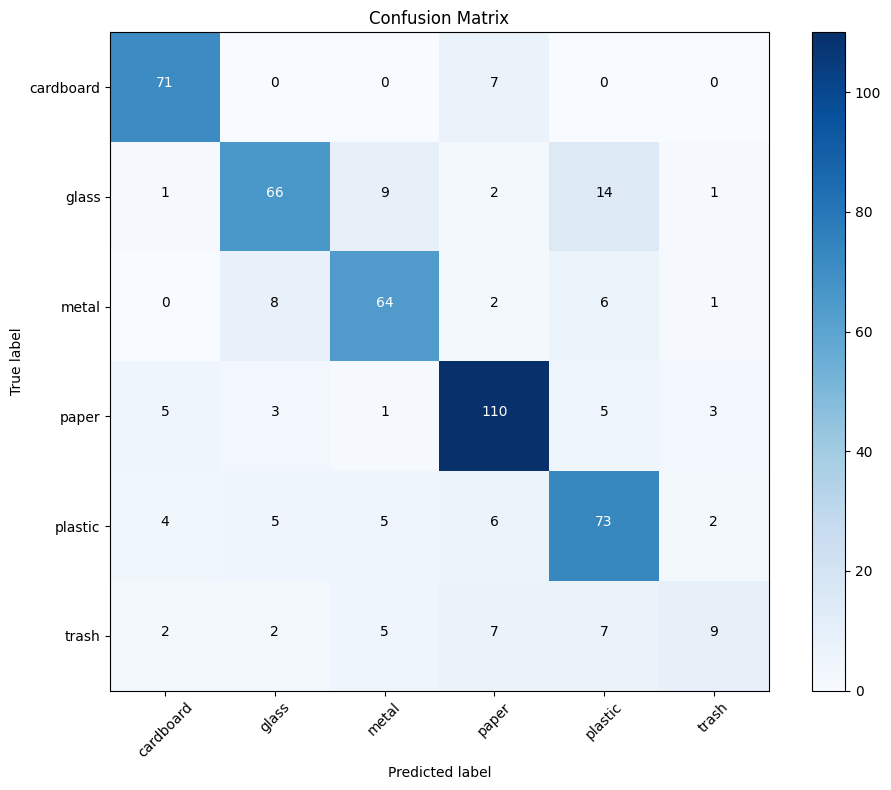

In [15]:
plot_confusion_matrix(labels, preds, train_dataset.dataset.classes)
